In [1]:
import pandas as pd
import numpy as np

In [14]:
df = pd.read_excel("../data/dfa_analysis_data.xlsx", sheet_name="factors")
df.set_index("Date", inplace=True)
df.head()

,Mkt-RF,SMB,HML,RF
Date,,,,
1926-07-31,0.0296,-0.0256,-0.0243,0.0022
1926-08-31,0.0264,-0.0117,0.0382,0.0025
1926-09-30,0.0036,-0.0140,0.0013,0.0023
1926-10-31,-0.0324,-0.0009,0.0070,0.0032
1926-11-30,0.0253,-0.0010,-0.0051,0.0031


In [28]:
idx_pre_1981 = df.index < '1981-01-01'
idx_1981_1990 = (df.index >= '1981-01-01') & (df.index < '1990-01-01')
idx_1990_2002 = (df.index >= '1990-01-01') & (df.index < '2002-01-01')
idx_1981_2002 = (df.index >= '1981-01-01') & (df.index < '2002-01-01')
idx_after_2002 = df.index >= '2002-01-01'

In [30]:
# 2.1.
from functools import partial

def performance_stat(s: pd.Series) -> pd.Series:
    """
    Calculate the mean, volatility, sharpe of given series
    
    Parameters:
        s (pd.Series): 
            Excess return of certain asset / portfolio
            Index: all time period (i.e. monthly)
            
    Returns:
        s_stat: Series contains mean, volatility, sharpe of the input series
    """
    s_stat = s.agg(['mean', 'std', partial(np.quantile, q=0.05, axis=0)]).T
    s_stat['mean'] *= 12
    s_stat['std'] *= (12 ** (1/2))
    s_stat['sharpe'] = s_stat['mean'] / s_stat['std']
    return s_stat.rename({"quantile": "var"})

pd.concat([
    performance_stat(df.loc[idx_pre_1981, "Mkt-RF"]).rename("mkt-pre-1981"),
    performance_stat(df.loc[idx_1981_2002, "Mkt-RF"]).rename("mkt-1981-2002"),
    performance_stat(df.loc[idx_after_2002, "Mkt-RF"]).rename("mkt-after-2002"),
    performance_stat(df.loc[idx_pre_1981, "SMB"]).rename("size-pre-1981"),
    performance_stat(df.loc[idx_1981_2002, "SMB"]).rename("size-1981-2002"),
    performance_stat(df.loc[idx_after_2002, "SMB"]).rename("size-after-2002"),
    performance_stat(df.loc[idx_pre_1981, "HML"]).rename("value-pre-1981"),
    performance_stat(df.loc[idx_1990_2002, "HML"]).rename("value-1990-2002"),
    performance_stat(df.loc[idx_1981_2002, "HML"]).rename("value-1981-2002"),
    performance_stat(df.loc[idx_after_2002, "HML"]).rename("value-after-2002"),
], axis=1).T

,mean,std,var,sharpe
mkt-pre-1981,0.081138,0.205050,-0.083985,0.395696
mkt-1981-2002,0.077257,0.157396,-0.064545,0.490847
mkt-after-2002,0.086187,0.155313,-0.079130,0.554923
size-pre-1981,0.033985,0.114568,-0.043400,0.296638
size-1981-2002,-0.000862,0.118346,-0.046515,-0.007283
size-after-2002,0.017486,0.086443,-0.038230,0.202280
value-pre-1981,0.049479,0.133825,-0.042910,0.369727
value-1990-2002,0.045542,0.124272,-0.045385,0.366466
value-1981-2002,0.063776,0.111183,-0.041790,0.573612
value-after-2002,-0.001710,0.107517,-0.041740,-0.015901


### 2.2.
1. Market factor: yes. Size: no for 1981-2002. Value: no for after 2002.
2. Yes.
3. Yes. 
4. Market has the highest premium > size > value (negative premium)

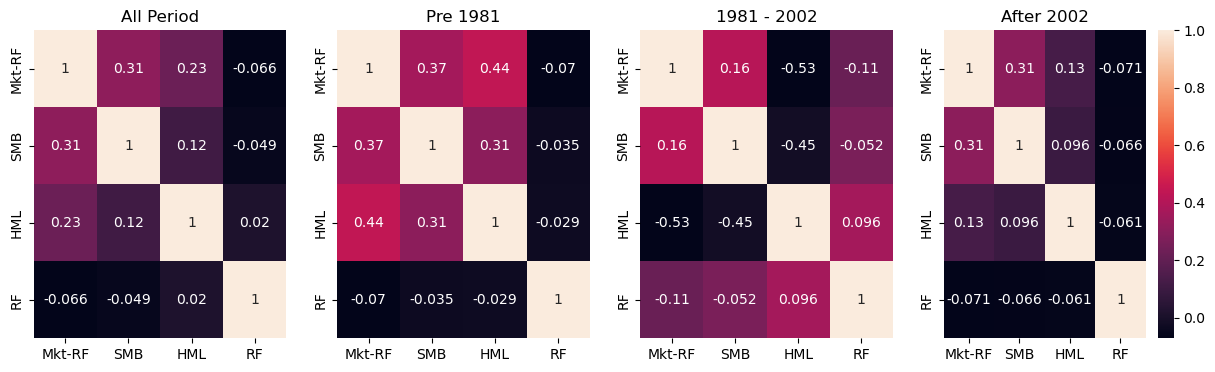

In [37]:
# 2.3. 
from seaborn import heatmap
import matplotlib.pyplot as plt 

f, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(15, 4))
heatmap(df.corr(), annot=True, ax=ax1, cbar=False)
ax1.title.set_text('All Period')
heatmap(df.loc[idx_pre_1981].corr(), annot=True, ax=ax2, cbar=False)
ax2.title.set_text('Pre 1981')
heatmap(df.loc[idx_1981_2002].corr(), annot=True, ax=ax3, cbar=False)
ax3.title.set_text('1981 - 2002')
heatmap(df.loc[idx_after_2002].corr(), annot=True, ax=ax4)
ax4.title.set_text('After 2002')

Yes. The highest correlation is HML-Mkt for pre-2018 at 0.44, which is still relatively low. 

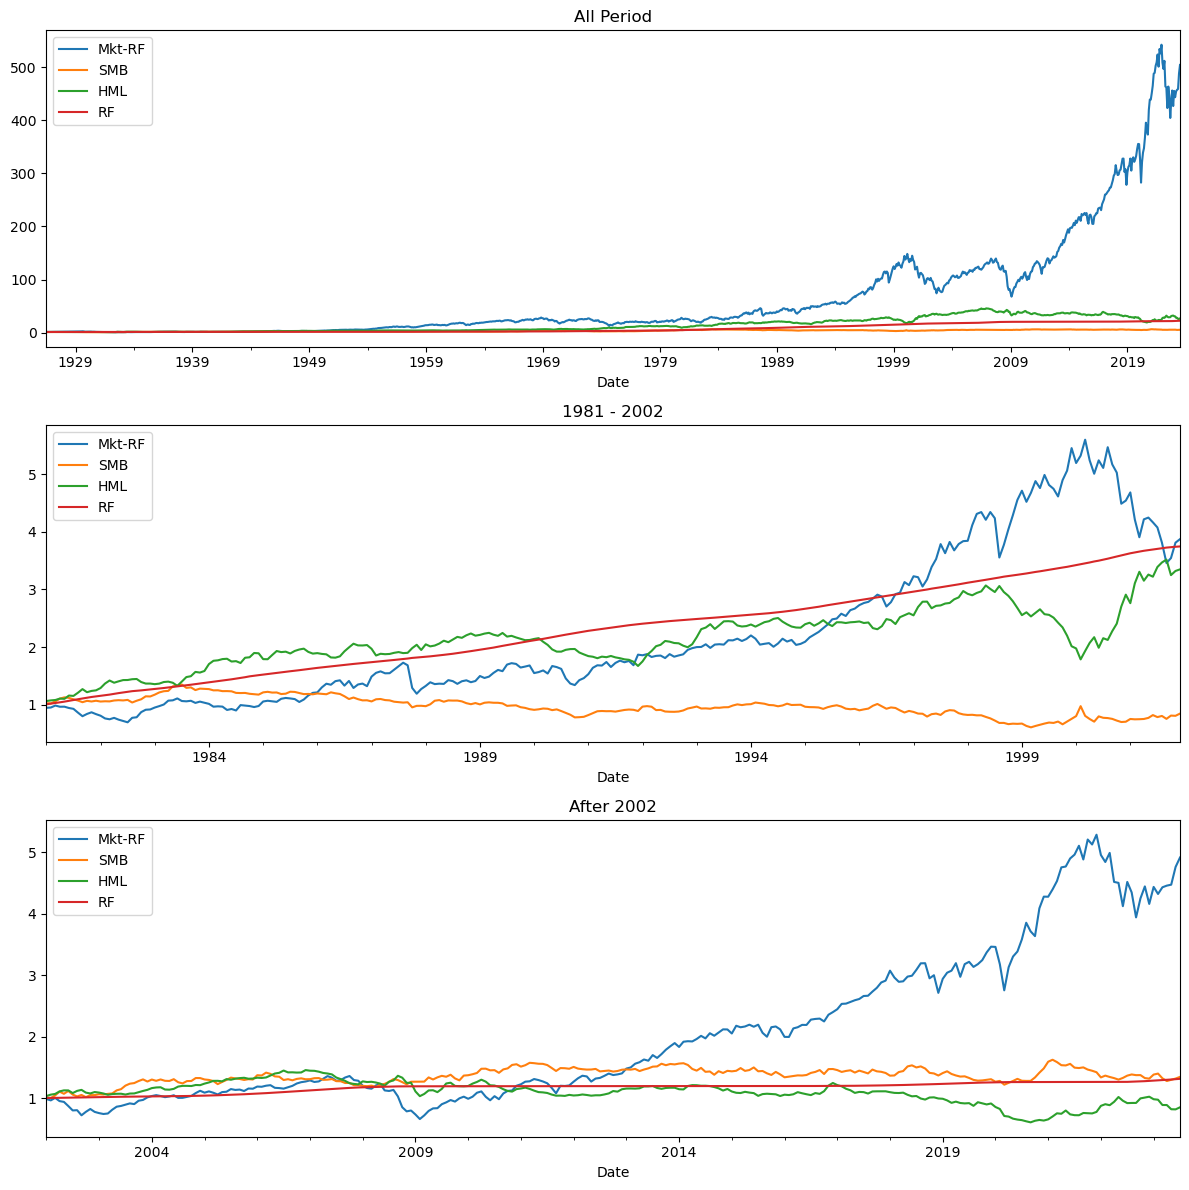

In [42]:
# 2.4. 
f1, (ax5, ax6, ax7) = plt.subplots(3, 1, figsize=(12, 12))

(df + 1).cumprod().plot(title="Cumulative Premium", ax=ax5)
ax5.title.set_text('All Period')
(df.loc[idx_1981_2002] + 1).cumprod().plot(title="Cumulative Premium (1981-2001)", ax=ax6)
ax6.title.set_text('1981 - 2002')
(df.loc[idx_after_2002] + 1).cumprod().plot(title="Cumulative Premium (after 2002)", ax=ax7)
ax7.title.set_text('After 2002')
f1.tight_layout()

### 2.5. 
During 1981-2001: Market / Value are valuable. After 2001: only market are valuable. 
DFA may want to emphasize on market only for future. 

In [60]:
# 3.1.
port = pd.read_excel("../data/dfa_analysis_data.xlsx", sheet_name="portfolios (total returns)")
port.set_index("Date", inplace=True)
port = port.subtract(df.loc[port.index, "RF"], axis=0)      # convert to excess return
port = port.loc[port.index > '1981-01-01']
port.head()

,SMALL LoBM,ME1 BM2,ME1 BM3,ME1 BM4,SMALL HiBM,ME2 BM1,ME2 BM2,ME2 BM3,ME2 BM4,ME2 BM5,...,ME4 BM1,ME4 BM2,ME4 BM3,ME4 BM4,ME4 BM5,BIG LoBM,ME5 BM2,ME5 BM3,ME5 BM4,BIG HiBM
Date,,,,,,,,,,,,,,,,,,,,,
1981-01-31,-0.054941,-0.014888,0.009909,0.005911,0.021085,-0.059733,-0.010738,-0.012684,0.007626,0.020623,...,-0.077022,-0.044926,-0.012942,-0.005534,0.003924,-0.071746,-0.083592,-0.074265,-0.010037,0.009464
1981-02-28,-0.044745,-0.010535,0.001444,0.009240,0.014398,-0.014473,0.005102,0.017420,0.024361,0.027939,...,0.002600,0.014707,0.034695,0.002673,0.027240,0.021950,0.009415,-0.016450,0.020446,-0.016853
1981-03-31,0.060718,0.082395,0.073568,0.077655,0.061040,0.068082,0.071500,0.066319,0.066325,0.063175,...,0.080443,0.055672,0.073222,0.061934,0.064868,0.017353,0.019940,-0.008875,0.022230,0.069573
1981-04-30,0.018141,0.035914,0.024600,0.036523,0.044090,0.006012,0.024744,0.026586,0.026781,0.029442,...,-0.010849,-0.019081,-0.006016,-0.007801,0.006253,-0.038311,-0.053508,-0.038006,0.010439,-0.040374
1981-05-31,0.038153,0.037824,0.032399,0.013389,0.016837,0.050452,0.010304,0.016889,-0.008609,0.013558,...,0.023970,0.010245,0.007640,-0.000759,0.021978,0.004288,-0.032791,-0.031355,0.026669,-0.005979


In [62]:
port_stat = port.apply(performance_stat, axis=0).T
port_stat

,mean,std,var,sharpe
SMALL LoBM,0.008607,0.272612,-0.121077,0.031572
ME1 BM2,0.091784,0.235700,-0.095709,0.389411
ME1 BM3,0.092669,0.197915,-0.085817,0.468227
ME1 BM4,0.117387,0.192404,-0.076442,0.610105
SMALL HiBM,0.129434,0.208295,-0.088647,0.621397
ME2 BM1,0.059889,0.244792,-0.103985,0.244654
ME2 BM2,0.101862,0.204197,-0.084928,0.498842
ME2 BM3,0.107086,0.184794,-0.079119,0.579484
ME2 BM4,0.108899,0.180701,-0.077423,0.602648
ME2 BM5,0.116268,0.213841,-0.096701,0.543715


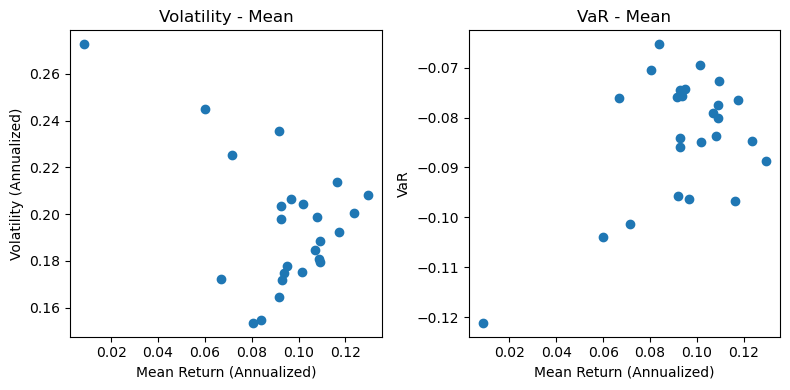

In [70]:
f2, (ax8, ax9) = plt.subplots(1, 2, figsize=(8, 4))
ax8.scatter(port_stat["mean"], port_stat["std"])
ax8.title.set_text('Volatility - Mean')
ax8.set_ylabel("Volatility (Annualized)")
ax8.set_xlabel("Mean Return (Annualized)")
ax9.scatter(port_stat["mean"], port_stat["var"])
ax9.title.set_text('VaR - Mean')
ax9.set_ylabel("VaR")
ax9.set_xlabel("Mean Return (Annualized)")
f2.tight_layout()
plt.show()

No. Neither volatility nor VaR can explain the differences in mean.


In [83]:
# 3.1 - 3.2
from sklearn.linear_model import LinearRegression

def linear_regression_stat(s: pd.Series) -> pd.Series:
    """
    Run linear regression of certain asset returns against merrill factors
    and calculate Market Beta / Treynor Ratio / Information Ratio
    
    Parameters:
        s (pd.Series): 
            Return series of certain asset
            
    Returns:
        pd.Series of all annualized statistics of given asset
    """
    spy = df.loc[df.index[df.index > '1981-01-01'], ["Mkt-RF"]]
    rf = df.loc[df.index[df.index > '1981-01-01'], "RF"]
    reg = LinearRegression().fit(spy, s)
    market_beta = reg.coef_[0]
    error_std = np.std(s - reg.predict(spy)) * np.sqrt(12)
    
    return pd.Series({
        "market_beta": market_beta,
        "treynor_ratio": (s - rf).mean() * 12 / market_beta,
        "alpha": reg.intercept_ * 12,
        "information_ratio": reg.intercept_ * 12 / error_std
    })

port_stat = port.apply(linear_regression_stat, axis=0).T
port_stat

,market_beta,treynor_ratio,alpha,information_ratio
SMALL LoBM,1.350120,-0.021424,-0.101810,-0.589896
ME1 BM2,1.160335,0.046756,-0.003112,-0.020671
ME1 BM3,1.034045,0.053323,0.008102,0.070898
ME1 BM4,0.967278,0.082557,0.038280,0.321632
SMALL HiBM,0.988304,0.092991,0.048608,0.347917
ME2 BM1,1.333429,0.016767,-0.049163,-0.382595
ME2 BM2,1.128858,0.056988,0.009541,0.092728
ME2 BM3,1.024793,0.067872,0.023275,0.252293
ME2 BM4,0.970403,0.073545,0.029536,0.300523
ME2 BM5,1.109383,0.070974,0.025540,0.204016


If CAPM were true, 
- Treynor Ratio should be a constant = expected return of market excess return, i.e. a function of market returns (SPY);
- Alpha should be low, ideally 0;
- Information Ratio should be low, ideally 0 too.

Our observations show inconsistency from all ideal cases above. 

In [99]:
# 3.3.
x_y = (port_stat[["market_beta"]], port.mean())
capm_reg = LinearRegression().fit(*x_y)
print("R2: {:.2f}%".format(capm_reg.score(*x_y) * 100))
print("Intercept: {:.4f}".format(capm_reg.intercept_))
print("Coefficient: {:.4f}".format(capm_reg.coef_[0]))

R2: 27.28%
Intercept: 0.0170
Coefficient: -0.0087


If CAPM were true, the cross-section estimation results should be:
- R2 should be very high, ideally 1;
- intercept should be low, ideally 0;
- Coefficient = Expected market returns, i.e. a function of market returns (SPY).

### 3.4
Yes. Because the results is showing market premium didn't fully explain the excess return. Therefore, other factors, e.g. value and size, must contribute to the excess returns.